# EM shower reconstruction at SND@LHC

1. __make sure the preprocessing has already been done__

2. __make sure `results` folder exists__


based on https://github.com/pauldebryas/SND_trackers_My_data/tree/SNDatLHC_neutrino

https://arxiv.org/pdf/2002.08722.pdf

In [1]:
# imports from utils.py & net.py
from utils import DataPreprocess, Parameters
from net import SNDNet, BNN, MyDataset, digitize_signal, digitize_signal_1d

# python
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pylab as plt
import time
from tqdm import tqdm
from IPython import display

# system
import os
import gc  # Gabage collector interface (to debug stuff)
import sys

# ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# dl
import torch
import torch.nn as nn

# bayesian
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

Welcome to JupyROOT 6.18/00


In [2]:
# Test to see if cuda is available or not + listed the CUDA devices that are available
try:
    assert(torch.cuda.is_available())
except:
    raise Exception("CUDA is not available")
    
n_devices = torch.cuda.device_count()
print("CUDA devices available:")

for i in range(n_devices):
    print("\t{}\twith CUDA capability {}".format(torch.cuda.get_device_name      (device=i), 
                                                 torch.cuda.get_device_capability(device=i)))

device = torch.device("cuda", 0)

CUDA devices available:
	Quadro P2200	with CUDA capability (6, 1)


In [3]:
# Turn off interactive plotting: for long run it screws up everything
plt.ioff()

In [4]:
DETECTOR_PARAMS = Parameters("SNDatLHC")
PATH_NUEL  = "~/snd_data/nue"
PATH_NUMU  = "~/snd_data/numu"
PATH_NUTAU = "~/snd_data/nutau"

# number of planes of the detector
NB_PLANE = len(DETECTOR_PARAMS.snd_params[DETECTOR_PARAMS.configuration]["TT_POSITIONS"])

## Data processing

Here we load and process __pickle__ files. 

In [5]:
from process_pickle import *

In [6]:
# reidx_TT_df, reidx_y_full = load_dataframes(DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [7]:
# merged_TT_df, merged_y_full = merge_events_arrays(reidx_TT_df, reidx_y_full)

In [8]:
# merged_y_full = normalise_target_energy(merged_y_full)

## Data preparation

Here we prepare (load or, if needed, create) the datasets.

In [9]:
from operate_datasets import *

In [10]:
# create_dataset('sum', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [11]:
# create_dataset('longitudal', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [12]:
# create_dataset('projection', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

In [13]:
# memory troubles!
# be very carefull when using this
### create_dataset('plane', DETECTOR_PARAMS, PATH_NUEL, PATH_NUMU, PATH_NUTAU)

## Model quality visualisation

In [14]:
from model_visualisation import *

In [15]:
from sklearn.metrics import *

def get_scores(y_train, y_pred):
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    score_func_arr = [explained_variance_score,
                      max_error,
                      mean_absolute_error,
                      mean_squared_error,
                      mean_squared_log_error, 
                      #mean_absolute_percentage_error, # update scikit to use
                      median_absolute_error,
                      r2_score]

    metric_func = explained_variance_score
    
    scores_dict = dict()

    for metric_func in score_func_arr:
        scores_dict[metric_func.__name__] = metric_func(y_train, y_pred)
        print(metric_func.__name__, metric_func(y_train, y_pred))
        
    return scores_dict

# Load datasets

In [16]:
def dataset_split(full_X, full_y):
    data_size = full_X.shape[0]

    # Train test split
    TRAIN_SIZE_RATIO = 0.9
    RANDOM_SEED = 1543

    all_idx = np.arange(0, data_size)

    train_idx, test_idx, _, _ = train_test_split(all_idx, all_idx, 
                                                 train_size=TRAIN_SIZE_RATIO, 
                                                 random_state=RANDOM_SEED)

    train_size = len(train_idx)
    test_size  = len(test_idx)

    X_train = full_X[train_idx]
    y_train = full_y[train_idx]

    X_test = full_X[test_idx]
    y_test = full_y[test_idx]
    
    return X_train, y_train

In [17]:
def dataset_clip(X_arr, y_arr, min_clip):
    clip_idx = np.where(X_arr > min_clip)[0]

    X_arr_clip = X_arr[clip_idx]#.reshape(-1, 1)
    y_arr_clip = y_arr[clip_idx]#.reshape(-1, 1)

    return X_arr_clip, y_arr_clip

## Support vector regression baseline

In [18]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'longitudal')
min_clip = 25

X_train, y_train = dataset_split(full_X, full_y)
X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [19]:
from sklearn import svm

reg_svr = svm.SVR(gamma='scale')
#reg_svr = svm.LinearSVR(max_iter=10**5)

reg_svr.fit(X_train, y_train)

score_svr = reg_svr.score(X_train, y_train)

print('SVM: ', score_svr)

y_pred_svr = reg_svr.predict(X_train)

SVM:  0.4880231440011321


In [20]:
X_sum = X_train.sum(axis=1).reshape(-1,1)
y_sum = y_train.reshape(-1,1)
y_pred_svr = y_pred_svr.reshape(-1,1)

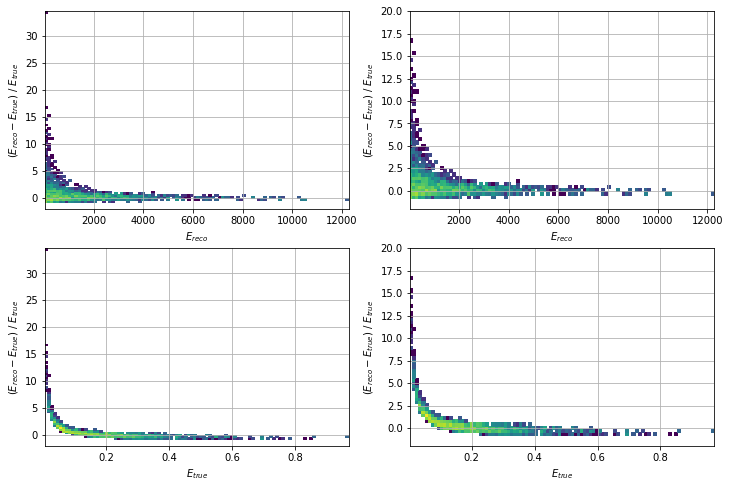

In [21]:
plot_res_vs_energy(X_sum, y_sum, y_pred_svr) 

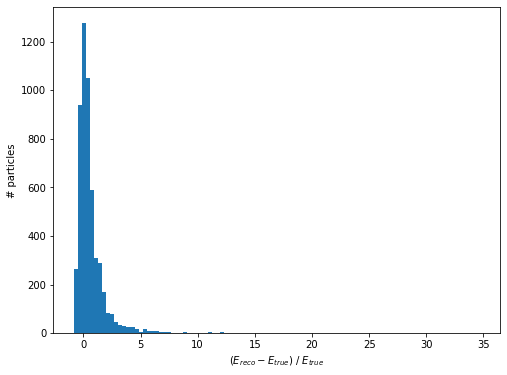

In [22]:
plot_res_hist(y_sum, y_pred_svr)

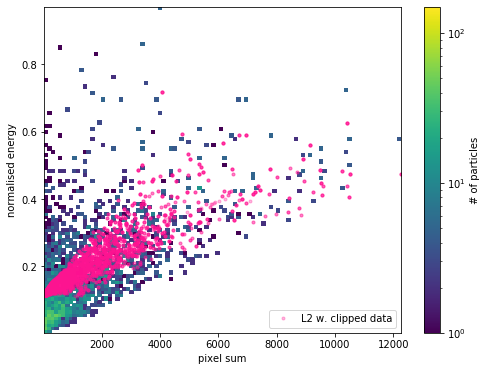

In [23]:
plot_2d_energy_hist(X_sum, y_sum, y_pred_svr)

In [24]:
get_scores(y_sum, y_pred_svr)

explained_variance_score 0.5018144715673952
max_error 0.6758947121300283
mean_absolute_error 0.07527675865873688
mean_squared_error 0.009606881636940881
mean_squared_log_error 0.006104335751157342
median_absolute_error 0.06983909554033953
r2_score 0.4880231440011321


{'explained_variance_score': 0.5018144715673952,
 'max_error': 0.6758947121300283,
 'mean_absolute_error': 0.07527675865873688,
 'mean_squared_error': 0.009606881636940881,
 'mean_squared_log_error': 0.006104335751157342,
 'median_absolute_error': 0.06983909554033953,
 'r2_score': 0.4880231440011321}

In [25]:
frac_resol = np.divide((y_pred_svr - y_sum), y_sum)

print((frac_resol < 0).sum())
print((frac_resol >= 0).sum())

1599
3725


## Linear regression baseline

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [27]:
full_X, full_y = load_dataset('~/snd_data/new_dataset/', 'sum')
min_clip = 25

X_train, y_train = dataset_split(full_X, full_y)
X_train, y_train = dataset_clip(X_train, y_train, min_clip)

In [28]:
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

In [29]:
reg_l2 = LinearRegression()   .fit(X_train, y_train) # positive=True ???
#reg_l1 = Lasso(positive=False).fit(X_train, y_train) # positive=True ???

score_l2 = reg_l2.score(X_train.reshape(-1, 1), y_train)

print('L2: ', score_l2)

y_pred_l2 = reg_l2.predict(X_train)

L2:  0.2362499696823066


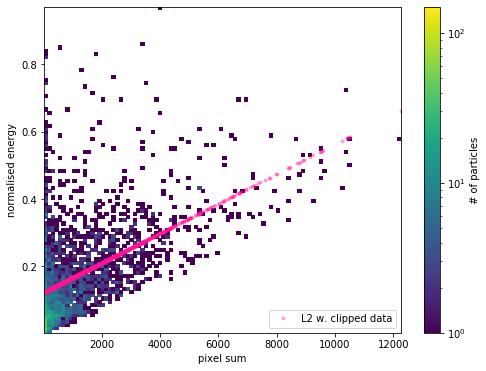

In [32]:
plot_2d_energy_hist(X_train, y_train, y_pred_l2) 

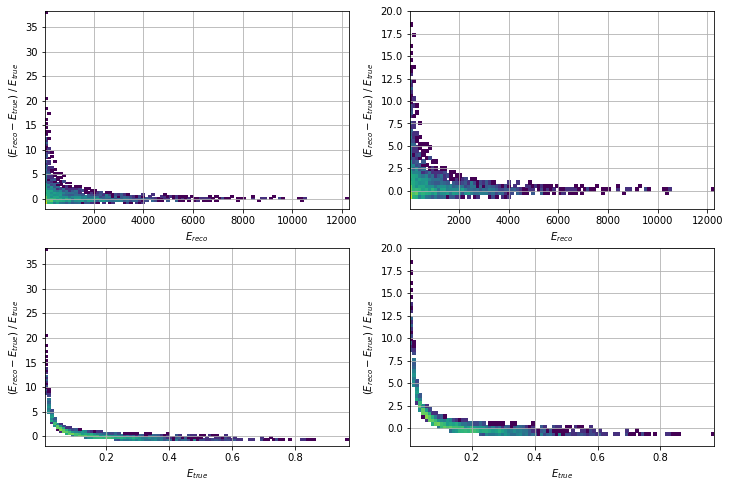

In [33]:
plot_res_vs_energy(X_train, y_train, y_pred_l2) 

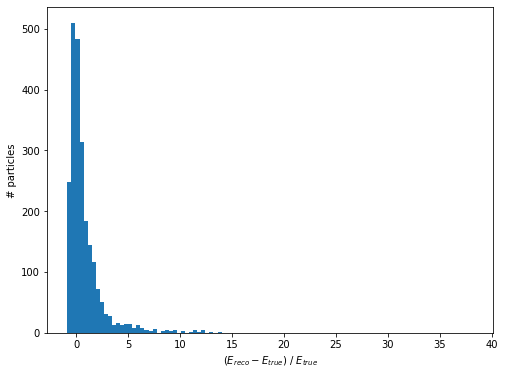

In [34]:
plot_res_hist(y_train, y_pred_l2)

In [36]:
get_scores(y_train, y_pred_l2)

explained_variance_score 0.2362499696823066
max_error 0.7200595932073045
mean_absolute_error 0.08855144221650643
mean_squared_error 0.015148897907780986
mean_squared_log_error 0.009410966036480279
median_absolute_error 0.07579413544166627
r2_score 0.2362499696823066


{'explained_variance_score': 0.2362499696823066,
 'max_error': 0.7200595932073045,
 'mean_absolute_error': 0.08855144221650643,
 'mean_squared_error': 0.015148897907780986,
 'mean_squared_log_error': 0.009410966036480279,
 'median_absolute_error': 0.07579413544166627,
 'r2_score': 0.2362499696823066}